In [1]:
### plot freeboards vs snow depth smoothed anomalies

In [ ]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings("ignore")

# Load SnowModel-LG data

In [2]:
#import SM-LG datafile that contains 2010-2020 data and create date list
snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined_regridded.npy')[3560:3742]
days = np.arange(0,182)
dates = [datetime.date(2019,10,1)+datetime.timedelta(days=np.int(days)) for days in days] # 2019-10-01 - 2020-03-31

# Define plotting functions

In [3]:
# functions to divide SM and WG data by region
datapath = '/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/'
m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l',round=True)
x_WG = np.load(datapath+'new_x_WG.npy')
y_WG = np.load(datapath+'new_y_WG.npy')
nsidc_lat = np.fromfile('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/psn25lats_v3.dat',dtype='<i4').reshape(448,304)/100000
nsidc_lon = np.fromfile('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/psn25lons_v3.dat',dtype='<i4').reshape(448,304)/100000
nsidc_x,nsidc_y = m(nsidc_lon,nsidc_lat)
file = Dataset('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/NSIDC_regions_Masks-2.nc')
mask = np.array(file['mask']).transpose(1,0).astype('float32')
mask_values = griddata((nsidc_x.ravel(),nsidc_y.ravel()),mask.ravel(),(x_WG,y_WG),'nearest')

def regions_WG(regs):

    WG_mean = []
    for i in range(len(dates)):
        if SAT == 'CS2_CPOM':
            WG = CS2_CPOM[i]
        elif SAT == 'S3_GPOD_Bristol':
            WG = S3_GPOD_Bristol[i]
        elif SAT == 'SM':
            WG = snow[i]
        elif SAT == 'CS2_Bristol':
            WG = CS2_Bristol[i]
        elif SAT == 'CS2_S3_GPOD':
            WG = CS2_S3_GPOD[i]
        WG_c = WG.copy()
        reg = np.isin(mask_values,regs)
        interp_mean = np.nanmean(WG_c[reg])
        WG_mean.append(interp_mean)

    return(WG_mean) 

In [4]:
# function to calculate running mean, where T = np.int(number of days/2)

def runningmean(SM_meanss,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(SM_meanss[0:i+T+1]))

    for i in range(T,np.size(SM_meanss)-T):
        r.append(np.nanmean(SM_meanss[i-T:i+T+1]))

    for i in range(np.size(SM_meanss)-T,np.size(SM_meanss)):
        r.append(np.nanmean(SM_meanss[i-T:]))

    return r

In [5]:
CS2_CPOM = []
S3_GPOD_Bristol = []
CS2_Bristol = []
CS2_S3_GPOD = []

missing = np.full((160,160),np.nan)
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/'
for sat,var in zip(['CS2_CPOM/','CS2_S3_GPOD/MERGE/','Bristol_LARM/CS2/freeboard/','GPOD_Bristol/S3/'],
                   [CS2_CPOM,CS2_S3_GPOD,CS2_Bristol,S3_GPOD_Bristol]):
    for i in dates:
        date = i.strftime("%Y%m%d")
        try:
            interp = np.load(datapath+sat+'FB_interp_2019-2020_50km_'+str(date)+'.npy')
            var.append(interp)
        except:
            var.append(missing)

# plot anomalies, with smoothing

Text(-0.03, 0.5, 'SnowModel Depth Smoothed Anomaly (m)')

<Figure size 432x288 with 0 Axes>

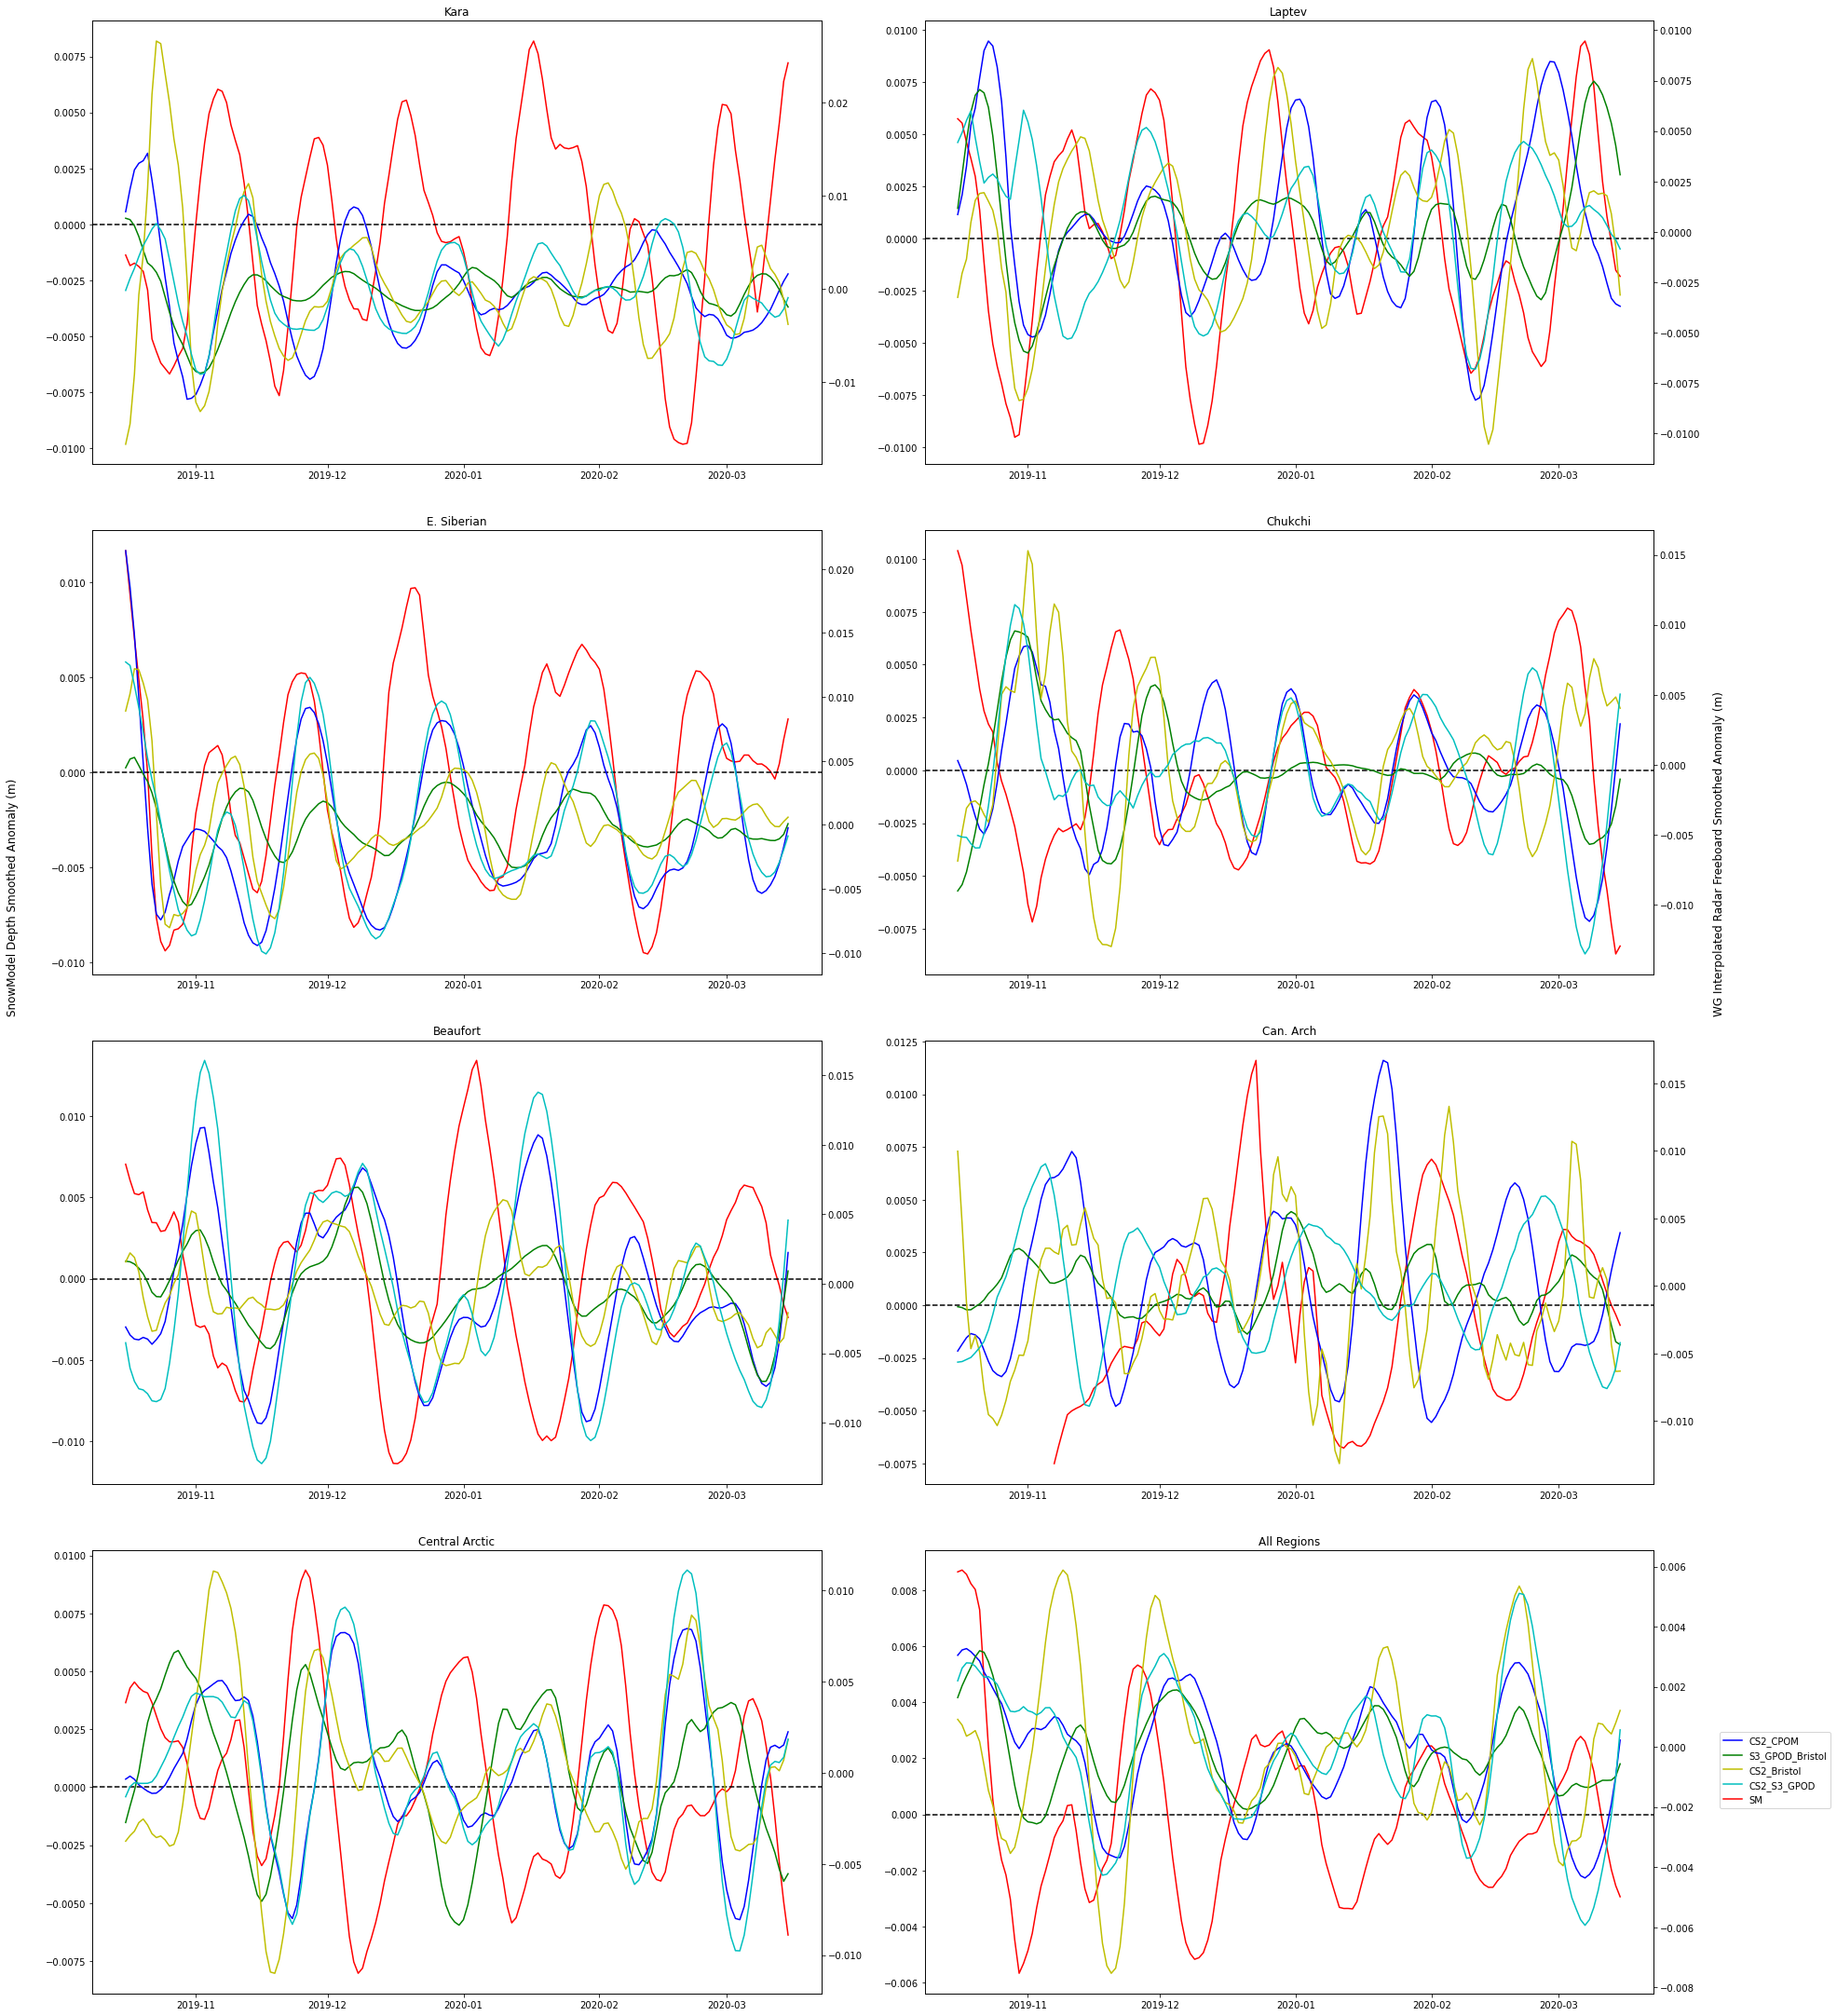

In [6]:
# we take a 30-day running mean of freeboard, then subtract this from the daily freeboards, then take a 9-day running mean of this
rm1 = 15
rm2 = 4

regions = [[9], [10], [11], [12], [13], [14], [15], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,21]]
reg_name = ['Kara', 'Laptev', 'E. Siberian', 'Chukchi','Beaufort', 'Can. Arch', 'Central Arctic', 'All Regions']

plt.figure()
fig, axs = plt.subplots(4,2,figsize=(24,30))
fig.tight_layout(w_pad=8,h_pad=5)

for counter, ax in enumerate(axs.reshape(-1)):

    SAT='SM'
    SM_means = regions_WG(regs=regions[counter])
    SAT='CS2_CPOM'
    CS2_CPOM_means = regions_WG(regs=regions[counter])
    SAT='S3_GPOD_Bristol'
    S3_GPOD_Bristol_means = regions_WG(regs=regions[counter])
    SAT='CS2_Bristol'
    CS2_Bristol_means = regions_WG(regs=regions[counter])
    SAT='CS2_S3_GPOD'
    CS2_S3_GPOD_means = regions_WG(regs=regions[counter])

    SM_smooth = runningmean(SM_means,T=15)
    CS2_CPOM_smooth = runningmean(CS2_CPOM_means,T=15)
    S3_GPOD_Bristol_smooth = runningmean(S3_GPOD_Bristol_means,T=15)
    CS2_Bristol_smooth = runningmean(CS2_Bristol_means,T=15)
    CS2_S3_GPOD_smooth = runningmean(CS2_S3_GPOD_means,T=15)

    SM_anom = runningmean(np.asarray(SM_means) - np.asarray(SM_smooth), T=4)
    CS2_CPOM_anom = runningmean(np.asarray(CS2_CPOM_means) - np.asarray(CS2_CPOM_smooth), T=4)
    S3_GPOD_Bristol_anom = runningmean(np.asarray(S3_GPOD_Bristol_means) - np.asarray(S3_GPOD_Bristol_smooth), T=4)
    CS2_Bristol_anom = runningmean(np.asarray(CS2_Bristol_means) - np.asarray(CS2_Bristol_smooth), T=4)
    CS2_S3_GPOD_anom = runningmean(np.asarray(CS2_S3_GPOD_means) - np.asarray(CS2_S3_GPOD_smooth), T=4)
    
    ax.plot(dates[(rm1):-(rm1)],SM_anom[(rm1):-(rm1)],color='r')
    ax1b = ax.twinx()
    ax1b.plot(dates[(rm1):-(rm1)],CS2_CPOM_anom[(rm1):-(rm1)],label='CS2_CPOM',color='b')
    ax1b.plot(dates[(rm1):-(rm1)],S3_GPOD_Bristol_anom[(rm1):-(rm1)],label='S3_GPOD_Bristol',color='g')
    ax1b.plot(dates[(rm1):-(rm1)],CS2_Bristol_anom[(rm1):-(rm1)],label='CS2_Bristol',color='y')
    ax1b.plot(dates[(rm1):-(rm1)],CS2_S3_GPOD_anom[(rm1):-(rm1)],label='CS2_S3_GPOD',color='c')
    ax1b.plot([dates[40]],[0],color='r',label='SM')
    
#     mask = ~np.isnan(np.asarray(CS2_CPOM_anom[(rm1):-(rm1)][:-1])) & ~np.isnan(np.asarray(SM_anom[(rm1):-(rm1)][:-1]))
#     rstats = pearsonr(np.asarray(CS2_CPOM_anom[(rm1):-(rm1)][:-1])[mask],np.asarray(SM_anom[(rm1):-(rm1)][:-1])[mask])
#     r = np.round(rstats[0],decimals=2)
#     p = np.round(rstats[1],decimals=3)
#     ax1b.annotate(f'r = {r}\np= {p}',xy=(0.01,0.93),va='bottom',ha='left',xycoords='axes fraction',color='b')
    
#     mask = ~np.isnan(np.asarray(S3_GPOD_Bristol_anom[(rm1):-(rm1)][:-1])) & ~np.isnan(np.asarray(SM_anom[(rm1):-(rm1)][:-1]))
#     rstats = pearsonr(np.asarray(S3_GPOD_Bristol_anom[(rm1):-(rm1)][:-1])[mask],np.asarray(SM_anom[(rm1):-(rm1)][:-1])[mask])
#     r = np.round(rstats[0],decimals=2)
#     p = np.round(rstats[1],decimals=3)
#     ax1b.annotate(f'r = {r}\np= {p}',xy=(0.01,0.85),va='bottom',ha='left',xycoords='axes fraction',color='g')

    ax.axhline(0,color='k',ls='--')
    ax.set_title(reg_name[counter])
    
plt.legend(bbox_to_anchor = (1.25, 0.6))
fig.text(1.03, 0.5, 'WG Interpolated Radar Freeboard Smoothed Anomaly (m)', ha='center', rotation='vertical', fontsize='large')
fig.text(-0.03, 0.5, 'SnowModel Depth Smoothed Anomaly (m)', ha='center', rotation='vertical', fontsize='large')
#plt.savefig('/Users/carmennab/PhD/OI_PolarSnow/figs/fig5.pdf',bbox_inches = "tight")

daily means 

In [7]:
dm = pd.read_csv('/Users/carmennab/PhD/OI_PolarSnow/dataframes/WG_vs_SM_dailymeans.csv',header=[0])

<Figure size 432x288 with 0 Axes>

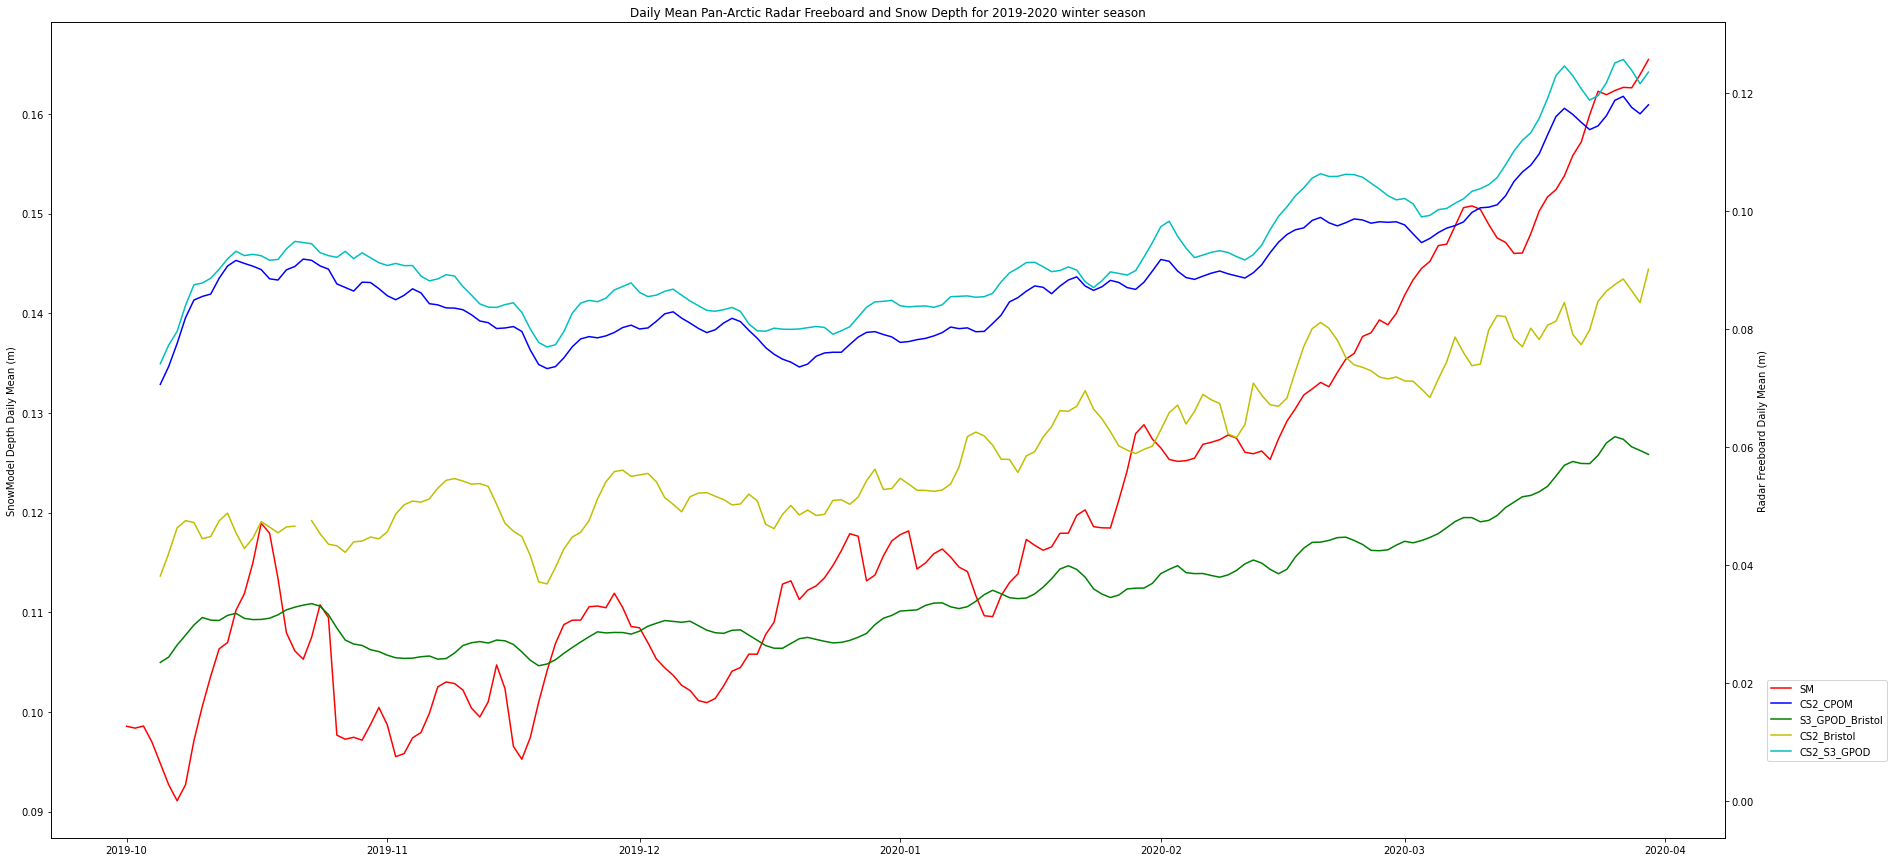

In [8]:
fb_cs2_cpom = dm['CS2_CPOM'][3560:3742]
fb_s3_gb = dm['S3_GPOD_Bristol'][3560:3742]
fb_cs2_b = dm['CS2_Bristol'][3560:3742]
fb_cs2_s3 = dm['CS2_S3_GPOD'][3560:3742]
sm = dm['SM'][3560:3742]

freeb_cs2_cpom = np.asarray(fb_cs2_cpom)
freeb_s3_gb = np.asarray(fb_s3_gb)
freeb_cs2_b = np.asarray(fb_cs2_b)
fb_cs2_s3 = np.asarray(fb_cs2_s3)
snow = np.asarray(sm)

plt.figure()

fig, ax = plt.subplots(1,1,figsize=(30,15))

ax.plot(dates,sm,label='SM',color='r')
ax.set_ylabel('SnowModel Depth Daily Mean (m)')
ax2 = ax.twinx()
ax2.plot([dates[40]],[0],color='r',label='SM')
ax2.set_ylabel('Radar Freeboard Daily Mean (m)')
ax2.plot(dates,freeb_cs2_cpom,label='CS2_CPOM',color='b')
ax2.plot(dates,freeb_s3_gb,label='S3_GPOD_Bristol',color='g')
ax2.plot(dates,freeb_cs2_b,label='CS2_Bristol',color='y')
ax2.plot(dates,fb_cs2_s3,label='CS2_S3_GPOD',color='c')
ax2.legend(bbox_to_anchor = (1.1, 0.2))
ax2.set_title('Daily Mean Pan-Arctic Radar Freeboard and Snow Depth for 2019-2020 winter season')
plt.show()
#plt.savefig('/Users/carmennab/PhD/OI_PolarSnow/figs/fig6.pdf',bbox_inches = "tight")